In [2]:
# import necessary libraries
# !pip install yfinance
# !pip install mplfinance
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
# get stock prices using yfinance library
def get_stock_price(symbol):
  df = yf.download(symbol, start='2021-02-01', threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df
symbol = 'COST'
# df = get_stock_price(symbol)

In [10]:
df = pd.read_csv('stock.csv')
df = df[['Date','Open','High','Low','Close']]
df.head()
# df.to_csv('stock.csv')

,Date,Open,High,Low,Close
0,2021-02-01,351.209991,352.790009,349.209991,350.519989
1,2021-02-02,351.760010,357.700012,350.720001,355.579987
2,2021-02-03,356.230011,357.529999,353.209991,355.209991
3,2021-02-04,356.709991,358.380005,353.850006,355.850006
4,2021-02-05,356.549988,356.850006,354.100006,355.170013


In [11]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0
# a list to store resistance and support levels
levels = []
for i in range(2, df.shape[0] - 2):  
  if is_support(df, i):    
    low = df['Low'][i]    
    if is_far_from_level(low, levels, df):      
      levels.append((i, low))  
  elif is_resistance(df, i):    
    high = df['High'][i]    
    if is_far_from_level(high, levels, df):      
      levels.append((i, high))

In [12]:
# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))   
  candlestick_ohlc(ax,df.values,width=0.6, colorup='green', 
    colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = 
      max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

[*********************100%***********************]  1 of 1 completed


<ipython-input-12-5e1550d4bd16>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


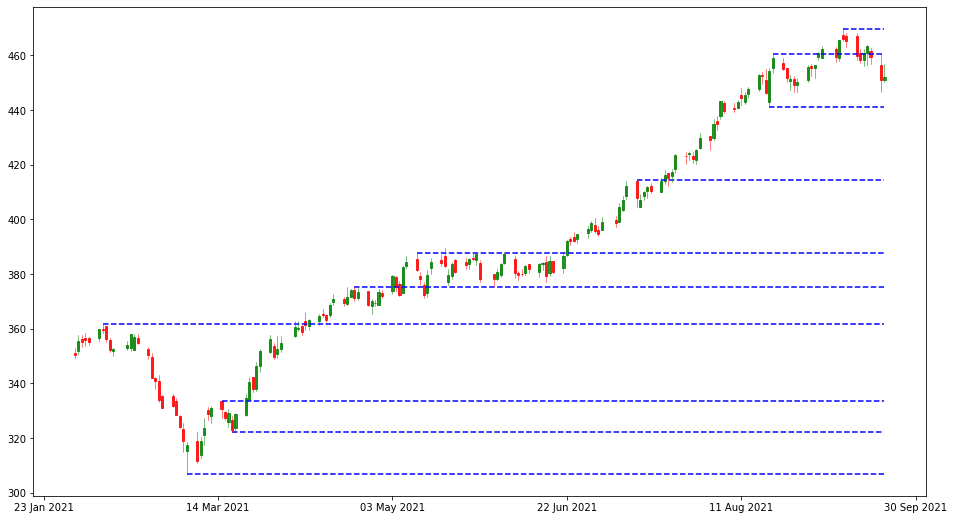

In [13]:
#method 2: window shifting method
#using the same symbol as the first example above
symbol = 'COST'
df = get_stock_price(symbol)
pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
  # taking a window of 9 candles
  high_range = df['High'][i-5:i+4]
  current_max = high_range.max()
  # if we find a new maximum value, empty the max_list 
  if current_max not in max_list:
    max_list = []
  max_list.append(current_max)
  # if the maximum value remains the same after shifting 5 times
  if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
      pivots.append((high_range.idxmax(), current_max))
    
  low_range = df['Low'][i-5:i+5]
  current_min = low_range.min()
  if current_min not in min_list:
    min_list = []
  min_list.append(current_min)
  if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
    pivots.append((low_range.idxmin(), current_min))
plot_all(pivots, df)

In [14]:
df

,Date,Open,High,Low,Close
Date,,,,,
2021-02-01,18659.0,351.209991,352.790009,349.209991,350.519989
2021-02-02,18660.0,351.760010,357.700012,350.720001,355.579987
2021-02-03,18661.0,356.230011,357.529999,353.209991,355.209991
2021-02-04,18662.0,356.709991,358.380005,353.850006,355.850006
2021-02-05,18663.0,356.549988,356.850006,354.100006,355.170013
...,...,...,...,...,...
2021-09-15,18885.0,458.239990,462.250000,456.140015,460.730011
2021-09-16,18886.0,460.790009,463.769989,456.570007,463.309998
2021-09-17,18887.0,461.619995,462.820007,457.019989,459.510010
